In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import expon, uniform, norm
from scipy import stats
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("PCS_TEST_DETERMINSTIC.xls")

In [3]:
df.head()

,Arrival no,Arrival time (sec),Base station,Call duration (sec),velocity (km/h)
0,1,0.000000,18,76.133611,125.934254
1,2,0.067744,7,159.056244,95.510881
2,3,0.559184,6,179.465053,127.757456
3,4,0.625319,14,163.108320,134.310552
4,5,1.345066,2,95.054472,112.272359


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Arrival no           10000 non-null  int64  
 1   Arrival time (sec)   10000 non-null  float64
 2   Base station         10000 non-null  int64  
 3   Call duration (sec)  10000 non-null  float64
 4   velocity (km/h)      10000 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 390.8 KB


## Statistical Analysis of Data

### Distributions of inter-arrival times of calls

In [5]:
arrivals = df[["Arrival time (sec)"]].copy()
arrivals.head()

,Arrival time (sec)
0,0.000000
1,0.067744
2,0.559184
3,0.625319
4,1.345066


In [6]:
arrivals["Inter-arrival time (sec)"] = arrivals["Arrival time (sec)"].diff()
arrivals.dropna(inplace = True)
arrivals.head()

,Arrival time (sec),Inter-arrival time (sec)
1,0.067744,0.067744
2,0.559184,0.491441
3,0.625319,0.066135
4,1.345066,0.719747
5,1.588020,0.242954


In [7]:
arrivals.describe()

,Arrival time (sec),Inter-arrival time (sec)
count,9999.000000,9999.000000
mean,6838.871872,1.369817
std,3954.622124,1.343922
min,0.067744,0.000025
25%,3402.816490,0.407874
50%,6804.923573,0.961708
75%,10257.241122,1.891807
max,13696.799448,12.498550


Fitted exponential parameters loc: 2.5090155759244226e-05, scale: 1.3697918363207653


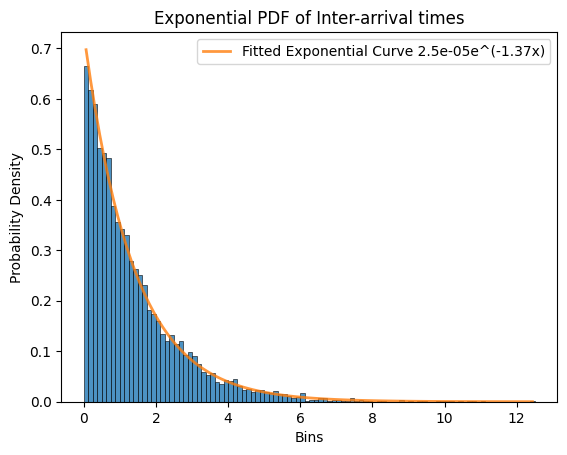

In [8]:
# Sample data (replace with your actual data)
# data = np.random.exponential(scale=1, size=1000)  # Simulates exponential data

# Create a histogram
counts, bin_edges, _  = plt.hist(arrivals["Inter-arrival time (sec)"].tolist(), bins=100, alpha=0.8, edgecolor='black', linewidth=0.5, density=True)  # Use density=True for probability density
# plt.grid(True)

# Extract bin centers
left_edges = bin_edges[:-1]
right_edges = bin_edges[1:]
bin_centers = (left_edges + right_edges) / 2  # Calculate bin centers

# Define the exponential function
# def exponential_func(x, a, b):
#   return a * np.exp(-b * x)

# Perform curve fitting (use counts if available)
# popt, pcov = curve_fit(exponential_func, bin_centers, counts)
# a, b = popt

# Get the fitted parameters
a, b = expon.fit(arrivals["Inter-arrival time (sec)"].tolist())
print(f'Fitted exponential parameters loc: {a}, scale: {b}')

# Generate x values for plotting the fitted curve
x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)

# Plot the histogram and fitted curve
exp_pdf = expon.pdf(x_fit, a, b)
plt.plot(x_fit, exp_pdf, alpha=0.8, linewidth=2, label=f'Fitted Exponential Curve {str(round(a, 6))}e^(-{str(round(b, 2))}x)')
# plt.plot(bin_centers, exponential_func(bin_centers, a, b), '-', alpha=0.8, linewidth=2, label=f'Fitted Exponential Curve {str(round(a, 2))}e^(-{str(round(b, 2))}x)')
plt.xlabel('Bins')
plt.ylabel('Probability Density')
plt.title('Exponential PDF of Inter-arrival times')
plt.legend()

plt.show()

We see that if we fit an exponential equation to the bin values, we obtain a nice fit over the histogram, suggesting that a strong exponential behaviour is present.

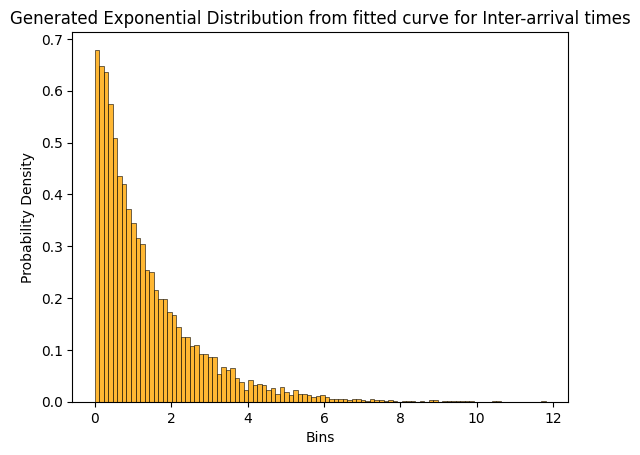

In [10]:
# Set a seed else the distribution will change slightly each time it is generated by scipy
np.random.seed(seed=3)
generated_interarrival_times = expon.rvs(loc=a, scale=b, size=10000)

plt.hist(generated_interarrival_times, bins=100, alpha=0.8, color = 'orange', edgecolor='black', linewidth=0.5, density=True)
plt.xlabel('Bins')
plt.ylabel('Probability Density')
plt.title('Generated Exponential Distribution from fitted curve for Inter-arrival times')
plt.show()

In order to use the KS-test to confirm that the underlying distribution of the inter-arrival times is exponential, we can test if the arrival times is uniformly distributed as a proxy. 

In [11]:
T = arrivals['Arrival time (sec)'].iloc[-1]
print(f"We hypothesize that Arrival Time is distributed over an interval from 0 to {T}")
normalized_arrival_times = arrivals['Arrival time (sec)']/T.copy()
normalized_arrival_times

We hypothesize that Arrival Time is distributed over an interval from 0 to 13696.799447838768


1       0.000005
2       0.000041
3       0.000046
4       0.000098
5       0.000116
          ...   
9995    0.999669
9996    0.999693
9997    0.999841
9998    0.999898
9999    1.000000
Name: Arrival time (sec), Length: 9999, dtype: float64

In [12]:
# Perform the Kolmogorov-Smirnov test
statistic, pvalue = stats.kstest(normalized_arrival_times.tolist(), uniform(loc=0, scale=1).cdf)

# Interpretation
alpha = 0.05  # Significance level

if pvalue > alpha:
  print("The data appears to be exponentially distributed (p-value:", pvalue, ").")
else:
  print("The data does not appear to be exponentially distributed (p-value:", pvalue, ").")

# Optional: Print the test statistic
print("Test statistic:", statistic)

The data appears to be exponentially distributed (p-value: 0.4934131792496401 ).
Test statistic: 0.00830155245298958


With normalization, our arrival times should be now uniformly distributed between 0 and 1. 

The p-value is higher than our threshold of 0.05, so we do not reject the null hypothesis that the normalized arrival times are distributed according to the uniform(0,1) distribution. Therefore, the inter-arrival times can be inferred to be exponential. 

The small test statistic shows that the max distance between the CDFs of the two distributions is minimal.

### Distributions of base station locations where calls are generated

In [13]:
locations = df[["Base station "]].copy()
locations.head()

,Base station
0,18
1,7
2,6
3,14
4,2


In [14]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Base station   10000 non-null  int64
dtypes: int64(1)
memory usage: 78.3 KB


In [15]:
locations.describe()

,Base station
count,10000.00000
mean,10.54220
std,5.78662
min,1.00000
25%,6.00000
50%,11.00000
75%,16.00000
max,20.00000


In [16]:
sorted(locations["Base station "].unique().tolist())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

We see that the base stations have IDs of 1 to 20. Let us do some exploration using a scatter plot

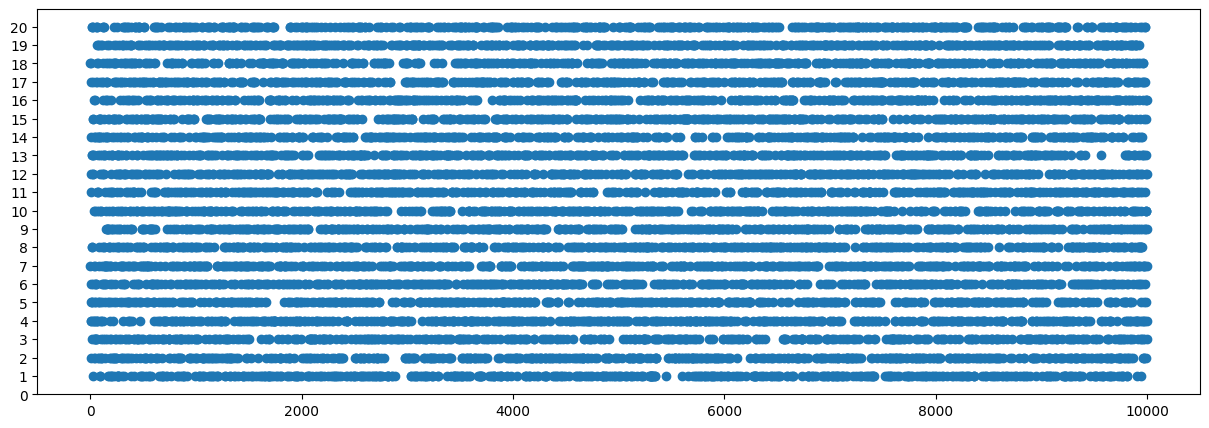

In [17]:
plt.figure(figsize=(15, 5))
plt.scatter(locations.index, locations)
plt.yticks(np.arange(0, 21, step=1))
plt.show()

The scatter plot shows quite a uniform spread of values across all records. We then use a histogram to better visualize the occurences/counts of the initial base station IDs

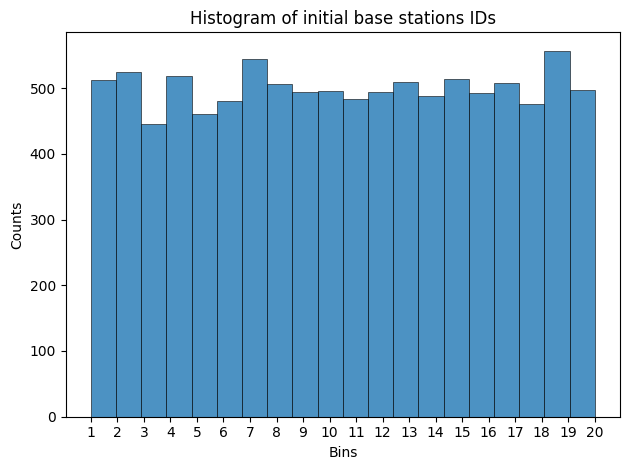

In [18]:
base_station_ids = locations["Base station "]

counts, bin_edges, _ = plt.hist(base_station_ids, edgecolor='black', linewidth=0.5, bins=20, alpha=0.8)

plt.xticks(np.arange(1, 21, step=1))
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.title('Histogram of initial base stations IDs')
plt.tight_layout()
plt.show()

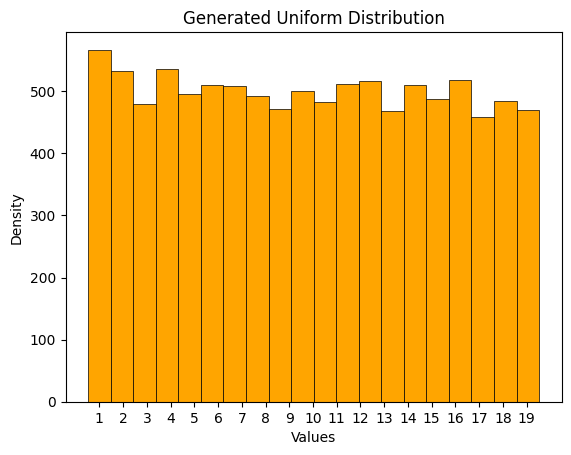

In [19]:
# uniform_distributions = np.random.uniform(1, 20, 10000) 
np.random.seed(seed=10)
generated_uniform_dist = uniform.rvs(loc=1, scale=19, size=10000)
count, bins, _ = plt.hist(generated_uniform_dist, bins = 20, edgecolor='black', linewidth=0.5, color='orange', align='left')
plt.title('Generated Uniform Distribution')
plt.xticks(np.arange(1, 20, step=1))
plt.ylabel('Density')
plt.xlabel('Values')
plt.show()

The histogram of the initial base station IDs looks very similar to our generated uniform distribution.
We can further verify this using goodness-of-fit tests.

In [20]:
frequencies = locations.groupby(["Base station "]).size().tolist()
# with just observed frequencies as the parameter, it is assumed that the expected frequencies are uniform and given by the mean of the observed frequencies.
stats.chisquare(frequencies)

Power_divergenceResult(statistic=25.656000000000002, pvalue=0.14006290765463547)

As the p value is > 0.05, we do not reject the null hypothesis that the initial base station ids are distributed according to a uniform distribution.

### Distributions of call durations

In [21]:
durations = df[["Call duration (sec)"]].copy()
durations.head()

,Call duration (sec)
0,76.133611
1,159.056244
2,179.465053
3,163.108320
4,95.054472


In [22]:
durations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Call duration (sec)  10000 non-null  float64
dtypes: float64(1)
memory usage: 78.3 KB


In [23]:
durations.describe()

,Call duration (sec)
count,10000.000000
mean,109.835901
std,99.138916
min,10.003952
25%,38.777914
50%,79.937560
75%,148.109589
max,1239.836192


Fitted exponential parameters loc: 10.003951603252272, scale: 99.83194913549542


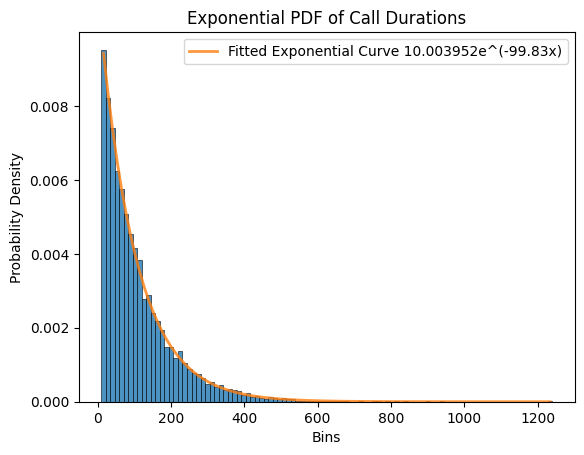

In [24]:
# Create a histogram
counts, bin_edges, _  = plt.hist(durations, bins=100, alpha=0.8, edgecolor='black', linewidth=0.5, density=True)  # Use density=True for probability density
# plt.grid(True)

# Extract bin centers
left_edges = bin_edges[:-1]
right_edges = bin_edges[1:]
bin_centers = (left_edges + right_edges) / 2  # Calculate bin centers

# # Define the exponential function
# def exponential_func(x, a, b):
#   return a * np.exp(-b * x)

# # Perform curve fitting (use counts if available)
# popt, pcov = curve_fit(exponential_func, bin_centers, counts)

# # Get the fitted parameters
# a, b = popt

a, b = expon.fit(durations["Call duration (sec)"].tolist())
print(f'Fitted exponential parameters loc: {a}, scale: {b}')

# Generate x values for plotting the fitted curve
x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)

# Plot the histogram and fitted curve
exp_pdf = expon.pdf(x_fit, a, b)
plt.plot(x_fit, exp_pdf, alpha=0.8, linewidth=2, label=f'Fitted Exponential Curve {str(round(a, 6))}e^(-{str(round(b, 2))}x)')
# plt.plot(bin_centers, exponential_func(bin_centers, a, b), '-', alpha=0.8, linewidth=2, label=f'Fitted Exponential Curve {str(round(a, 2))}e^(-{str(round(b, 2))}x)')
plt.xlabel('Bins')
plt.ylabel('Probability Density')
plt.title('Exponential PDF of Call Durations')
plt.legend()

plt.show()

If we generate the values based on our fitted exponential curve parameters, we know get the same distribution.

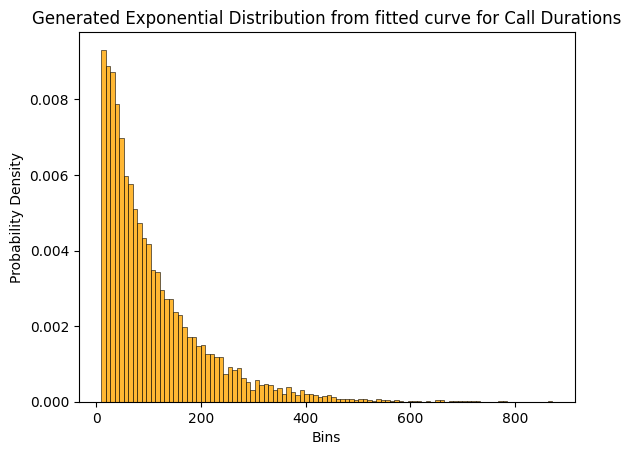

In [25]:
# Set a seed else the distribution will change slightly each time it is generated by scipy
np.random.seed(seed=3)
generated_duration_times = expon.rvs(loc=a, scale=b, size=10000)

plt.hist(generated_duration_times, bins=100, alpha=0.8, color = 'orange', edgecolor='black', linewidth=0.5, density=True)
plt.xlabel('Bins')
plt.ylabel('Probability Density')
plt.title('Generated Exponential Distribution from fitted curve for Call Durations')
plt.show()

In [26]:
# Normalize the exponential values. Call durations are alike to inter-arrival times. 
# Similiar to what we did with arrival times, we calcualte the normalized version of call times here.

call_times = durations.cumsum()
T = call_times.iloc[-1]
normalized_call_times = call_times / T
normalized_call_times

,Call duration (sec)
0,0.000069
1,0.000214
2,0.000378
3,0.000526
4,0.000613
...,...
9995,0.999432
9996,0.999466
9997,0.999495
9998,0.999847


In [27]:
# Perform the Kolmogorov-Smirnov test
statistic, pvalue = stats.kstest(normalized_call_times["Call duration (sec)"].tolist(), uniform(loc=0, scale=1).cdf)

# Interpretation
alpha = 0.05  # Significance level

if pvalue > alpha:
  print("The data appears to be exponentially distributed (p-value:", pvalue, ").")
else:
  print("The data does not appear to be exponentially distributed (p-value:", pvalue, ").")

# Optional: Print the test statistic
print("Test statistic:", statistic)

The data appears to be exponentially distributed (p-value: 0.3451676908068886 ).
Test statistic: 0.009341884814539125


The p-value is higher than our threshold of 0.05, so we do not reject the null hypothesis that the normalized call times are distributed according to the uniform(0,1) distribution. Therefore, the call durations can be inferred to be exponential. 

The small test statistic shows that the max distance between the CDFs of the two distributions is minimal.

### Distributions of car speeds

In [4]:
speeds = df[['velocity (km/h)']].copy()
speeds.head()

,velocity (km/h)
0,125.934254
1,95.510881
2,127.757456
3,134.310552
4,112.272359


In [5]:
speeds.describe()

,velocity (km/h)
count,10000.000000
mean,120.072098
std,9.019058
min,86.423152
25%,113.892676
50%,120.021618
75%,126.188008
max,151.501467


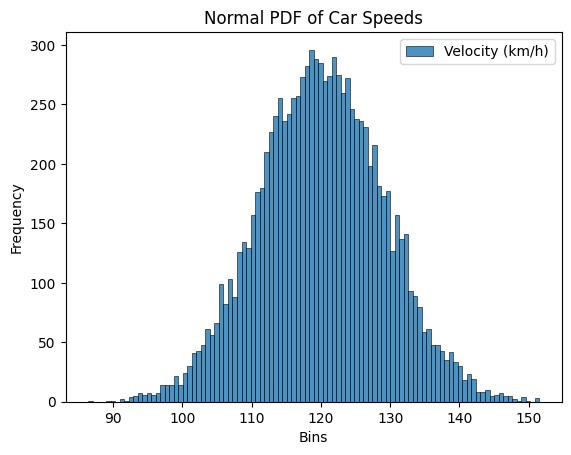

In [6]:
counts, bin_edges, _  = plt.hist(speeds, bins=100, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Normal PDF of Car Speeds')
plt.legend(['Velocity (km/h)'])
plt.show()

In [7]:
np.mean(speeds['velocity (km/h)'])

120.07209801685764

In [8]:
np.std(speeds['velocity (km/h)'])

9.018606933727643

We recreate the normal distribution using the mean and std

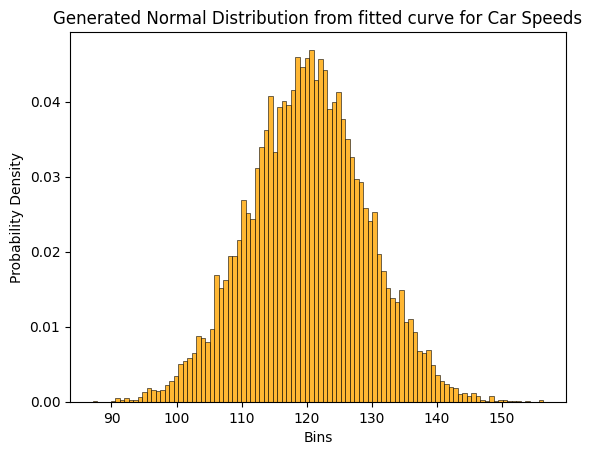

In [9]:
np.random.seed(seed=1)
generated_norm_dist = norm.rvs(loc=np.mean(speeds['velocity (km/h)']), scale=np.std(speeds['velocity (km/h)']), size=10000)
# print(generated_norm_dist)

plt.hist(generated_norm_dist, bins=100, alpha=0.8, color = 'orange', edgecolor='black', linewidth=0.5, density=True)
plt.xlabel('Bins')
plt.ylabel('Probability Density')
plt.title('Generated Normal Distribution from fitted curve for Car Speeds')
plt.show()

In [42]:
# Perform the Kolmogorov-Smirnov test
statistic, pvalue = stats.kstest(speeds['velocity (km/h)'].tolist(), norm(loc=np.mean(speeds['velocity (km/h)']), scale=np.std(speeds['velocity (km/h)'])).cdf)

# Interpretation
alpha = 0.05  # Significance level

if pvalue > alpha:
  print("The data appears to be exponentially distributed (p-value:", pvalue, ").")
else:
  print("The data does not appear to be exponentially distributed (p-value:", pvalue, ").")

# Optional: Print the test statistic
print("Test statistic:", statistic)

The data appears to be exponentially distributed (p-value: 0.7987384412526035 ).
Test statistic: 0.006439789372511606


The p-value is higher than our threshold of 0.05, so we do not reject the null hypothesis that the car speeds are distributed according to a normal distribution with its calculated mean and std. Therefore, the car speeds can be inferred to be normal. 

The small test statistic shows that the max distance between the CDFs of the two distributions is minimal.